# Using The Super Resolution Convolutional Neural Network(Deep Neural N/W) for Image Restoration


In [4]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
#from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import numpy as np
import math
import os

# python magic function, displays pyplot figures in the notebook instead of separate display window
%matplotlib inline

# 1. Image Quality Metrics
The structural similiarity (SSIM) index was imported directly from the scikit-image library; however, we will have to define our own functions for the PSNR and MSE.

In [6]:
#define a function for peak signal-to-noise ratio (PSNR)
def psnr(target,ref):#target image and refernce image
    
    #assume RGB image and convert all integer values to float
    target_data=target.astype(float)
    ref_data=ref.astype(float)
    
    diff=ref_data-target_data
    diff=diff.flatten('C')#need ot flatten so computations can be done
    
    rmse=math.sqrt(np.mean(diff**2.))#2. for float values
    
    return 20*math.log10(255./rmse)

#define function for mean squared error(MSE)
def mse(target,ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err=np.sum((target.astype('float')-ref.astype('float'))**2)
    err=err/float(target.shape[0]*target.shape[1])#divided by total number of pixels
    
    return err

# define function that combines all three image quality metrics
def compare_images(target,ref):
    scores=[]
    scores.append(psnr(target,ref))
    scores.append(mse(target,ref))
    scores.append(ssim(target,ref,multichannel=True))#multichannel so that it can handle 3Dor 3 channel images RGB/BGR 
    
    return scores

# 2. Preparing Images


using the same images that were used in the original SRCNN paper. We can download these images from http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html.

In [7]:
import os
import cv2

# prepare degraded images by introducing quality distortions resizing

def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        print(type(file))
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, c = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR) #interploation are methods for resizing images;how do you go from image with 100px to 1000px 
        #bilinear interpolation
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('low_res/{}'.format(file), img) 

In [8]:
#prepare_images('source/',2)
prepare_images('../../Licence_Plate_images/Train',2)
#source folder has high resolution images that will be converted to low resoltion images to be used for SRCNN

<class 'str'>
Saving 539096.jpg
<class 'str'>
Saving 539097.jpg
<class 'str'>
Saving 539098.jpg
<class 'str'>
Saving 539099.jpg
<class 'str'>
Saving 539100.jpg
<class 'str'>
Saving 539101.jpg
<class 'str'>
Saving 539102.jpg
<class 'str'>
Saving 539103.jpg
<class 'str'>
Saving 539104.jpg
<class 'str'>
Saving 539105.jpg
<class 'str'>
Saving 539106.jpg
<class 'str'>
Saving 539107.jpg
<class 'str'>
Saving 539108.jpg
<class 'str'>
Saving 539109.jpg
<class 'str'>
Saving 539110.jpg
<class 'str'>
Saving 539111.jpg
<class 'str'>
Saving 539112.jpg
<class 'str'>
Saving 539114.jpg
<class 'str'>
Saving 539116.jpg
<class 'str'>
Saving 539117.jpg
<class 'str'>
Saving S__19808258.jpg
<class 'str'>
Saving S__19808259.jpg
<class 'str'>
Saving S__19808266.jpg
<class 'str'>
Saving S__19808268.jpg
<class 'str'>
Saving S__19808269.jpg
<class 'str'>
Saving S__19808270.jpg
<class 'str'>
Saving S__19808271.jpg
<class 'str'>
Saving S__19808272.jpg
<class 'str'>
Saving S__19808273.jpg
<class 'str'>
Saving S__198

opencv is incredibly fast as it is designed for reat time computer vision application

new image(degraded) are of same resolution as base images.When sizing down the image we store the original pixel info in smaller area so we lost that info when sizing up the image.

# 3. Testing Low Resolution Images
To ensure that our image quality metrics are being calculated correctly and that the images were effectively degraded, lets calculate the PSNR, MSE, and SSIM between our reference images and the degraded images that we just prepared.

In [9]:
#test the generated umages using the image quality metrics

for file in os.listdir('low_res/'):
    
    #open target and reference images
    target=cv2.imread('low_res/{}'.format(file))
    ref = cv2.imread('../../Licence_Plate_images/Train/{}'.format(file))
    
    #calculate scores
    scores=compare_images(target,ref)
    
     # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))
        

539096.jpg
PSNR: 24.992018008649055
MSE: 618.0161364822784
SSIM: 0.7213493096186391

539097.jpg
PSNR: 26.8638441708883
MSE: 401.62172625097463
SSIM: 0.794706954248234



KeyboardInterrupt: 

SSIM: 0.0 to 1.0 shows similarity between images
MSE: Higher it is lower the resolution of the image
PSNR: want it to be as high as possible cuz we want noise tobe low and it is the ratio of signal to noise

# 4. Building the SRCNN Model
 In Keras, it's as simple as adding layers one after the other. The achitecture and hyper parameters of the SRCNN network can be obtained from the publication referenced above.

In [10]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    #add model layers;filters =no. of nodes in the layer
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))#only if in keras.json image_data_format is channels_last; else if channels_first then 1,None,None
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    #input_shape takes image of any height and width as long it is one channel
    #that is how the SRCNN handles input,it handles image slice inputs, it doesn't work at all 3 channels at once
    #SRCNN was trained on the luminescence channel in the YCrCb color space 
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

# 5. Deploying the SRCNN
Now that we have defined our model, we can use it for single-image super-resolution, **AFTER** preprocessing the images extensively before using them as inputs to the network. This processing will include cropping and color space conversions.

Additionally, to save us the time it takes to train a deep neural network, we will be loading pre-trained weights for the SRCNN. These weights can be found at the following GitHub page: https://github.com/MarkPrecursor/SRCNN-keras

Once we have tested our network, we can perform single-image super-resolution on all of our input images. Furthermore, after processing, we can calculate the PSNR, MSE, and SSIM on the images that we produce. We can save these images directly or create subplots to conveniently display the original, low resolution, and high resolution images side by side.

In [11]:
# define necessary image processing functions

#necessary cuz when we run images through SRCNN based on the kernel sizes and convulational layers, we are going to lose some of these outside pixels
#the images are going to get smaller and that's why it is neccesary to have a divisible image size 
def modcrop(img,scale):
    #temp size
    tmpsz=img.shape
    sz=tmpsz[0:2]
    
    #ensures that dimension of our image are divisible by scale(doesn't leaves hanging remainders) by cropping the images size
    #np.mod returns the remainder bewtween our sz and scale
    sz=sz-np.mod(sz,scale)
    
    img=img[0:sz[0],1:sz[1]]
    return img

#crop offs the bordersize from all sides of the image
def shave(image,border):
    img=image[border: -border,border:-border]
    return img

In [12]:
#define main prediction function

def predict(image_path):
    
    #load the srcnn model with weights cuz deep learning neural n/w take lot of time to train(have to feed in large amount of input data)
    srcnn=model()
    srcnn.load_weights('3051crop_weight_200.h5')
     
    #load the degraded and reference images
    #in opencv, images are loaded as BGR channels
    path,file=os.path.split(image_path)
    degraded=cv2.imread(image_path)
    ref=cv2.imread('../../Licence_Plate_images/Train/{}'.format(file))
    
    #preprocess the image with modcrop
    ref=modcrop(ref,3)#when calculating our image quality metrics later we have the same size image to what we produce in SRCNN network
    degraded=modcrop(degraded,3)
    
    #convert the image to YCrCb(3 channel image) - (srcnn trained on Y channel)
    temp=cv2.cvtColor(degraded,cv2.COLOR_BGR2YCrCb)
    #opencv does a very good job in converting from rgb to YCrCb and back
    
    #create image slice and normalize cuz SRCNN works on one dimensional input(or 3D inputs of depth 1 ,ie, inputs with one channel)
    Y=numpy.zeros((1,temp.shape[0],temp.shape[1],1),dtype=float)
    #create a numpy array the we fill with data,temp.shape[0]=width,[1]=height and last one means one channel(essentially like batch=1 cuz that's what going to get passed to the n/w ')
    #fill in the data; all values are normalized to between 0 and 1 as that's how srcnn was trained
    Y[0,:,:,0]=temp[:,:,0].astype(float)/255
    #first 0 means 0th index(we are saying that batch size is 1); :,: means every point in these channels; last 0 means first channel,ie, all the pixels in first luminescence channel
    #so we have our image slice, we have the Y channel, which is the first channel(index 0) out of the image that we converted to YCrCb color space
    
    #perform super-resolution with srcnn
    pre=srcnn.predict(Y,batch_size=1)#that's why we had index 0  above cuz we are saying that batch size is 1
    
    #post-process output cuz pre is still normalized
    pre*=255#multiplying every pixel by 255
    pre[pre[:]>255]=255#any pixels >255 set it =255 to prevent any rounding errors due to multiplication
    pre[pre[:]<0] =0# same reason as above
    pre=pre.astype(np.uint8)#convert float back to int values
    
    #cuz this is only the luminescence channel in the pre ,SO
    #copy Y channel back to image and convert to BGR
    temp=shave(temp,6)#accd.to tutor it loses 3 pixels on each side so if we shave this with a border 6,we can crop it appropriately there, so it is the same size as our output
    #if not agree with tutor, use print statements to see the specific dimensions
    
    # for the first channel(Y channel), copy in the output of our network
    temp[:,:,0]=pre[0,:,:,0]
    #So we are keeping the red difference and blue difference, channels 1 and 2, in this temp image which is in the YCrCb color space
    #and in the first one we are copying in our ouput,our luminiscence channel
    
    #convert back to bgr
    output=cv2.cvtColor(temp,cv2.COLOR_YCrCb2BGR)
    
    #emove borderfrom reference and degraded image, so that all our images(ref,degraded(low res.), and ouput(high res.)) are of the same size
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))#degraded wrt ref
    scores.append(compare_images(output, ref))#high res. output wrt ref
    
    # return images and scores
    return ref, degraded, output, scores

C:\Users\Computer\AppData\Local\Programs\Python\Python38\Lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Degraded Image: 
PSNR: 24.97366666148199
MSE: 620.6331221554204
SSIM: 0.7207113230114182

Reconstructed Image: 
PSNR: 25.752014964881877
MSE: 518.8001812028712
SSIM: 0.787892605341827



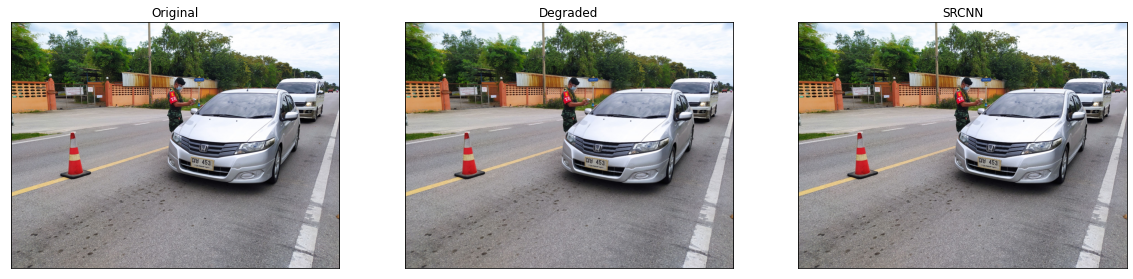

In [13]:
ref,degraded,output,scores=predict('low_res/539096.jpg')
# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))#1 row,3 columns
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))#first subplot
#imshow assumes RGB images but cv2 loads images as BGR else channel mixing will take place and we will get weird images
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))#2nd subplot
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])#leave them blank to remove ticks
    ax.set_yticks([])

All the image quality metrics got better; PSNR increased, MSE devreased and SSIM increased from degraded image to reconstructed image

KeyboardInterrupt: 

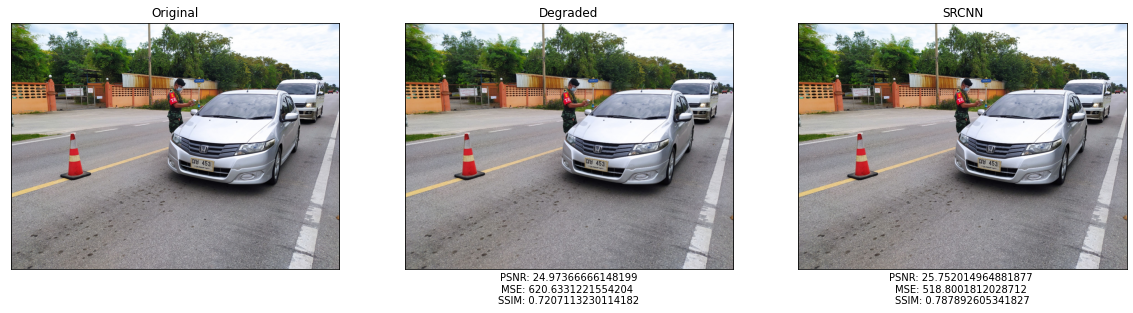

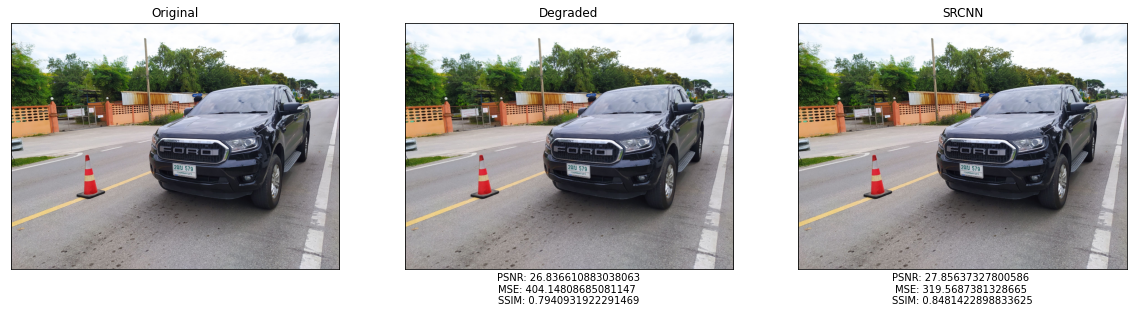

In [20]:
for file in os.listdir('low_res'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('low_res/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
#     print('Saving {}'.format(file))
#     fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
#     plt.close()